### Importing Libraries

In [216]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.stem.lancaster import LancasterStemmer



# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity



# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas


# twitter
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config

### Reading the Data

In [217]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
full_dir = main_dir + 'data_full/'
id_dir   = main_dir + 'data/'

popularity_list = []
text_list = []
entities_list = []

for file in sorted(os.listdir(full_dir))[:-2]:
    print('reading... ' + file)
    
    df_full = pd.read_csv(full_dir + file)

    text_list.append(df_full[['id', 'full_text']])
    popularity_list.append(df_full[['id', 'retweet_count', 'favorite_count']])
    entities_list.append(df_full[['id', 'entities']])
    
    print(file + ' ..done')
    print()

reading... 05-01-2020_full.csv
05-01-2020_full.csv ..done

reading... 05-02-2020_full.csv
05-02-2020_full.csv ..done

reading... 05-03-2020_full.csv
05-03-2020_full.csv ..done

reading... 05-04-2020_full.csv
05-04-2020_full.csv ..done

reading... 05-05-2020_full.csv
05-05-2020_full.csv ..done

reading... 05-06-2020_full.csv
05-06-2020_full.csv ..done

reading... 05-07-2020_full.csv
05-07-2020_full.csv ..done

reading... 05-08-2020_full.csv
05-08-2020_full.csv ..done

reading... 05-09-2020_full.csv
05-09-2020_full.csv ..done

reading... 05-10-2020_full.csv
05-10-2020_full.csv ..done

reading... 05-11-2020_full.csv
05-11-2020_full.csv ..done

reading... 05-12-2020_full.csv
05-12-2020_full.csv ..done

reading... 05-13-2020_full.csv
05-13-2020_full.csv ..done

reading... 05-14-2020_full.csv
05-14-2020_full.csv ..done

reading... 05-15-2020_full.csv
05-15-2020_full.csv ..done

reading... 05-16-2020_full.csv
05-16-2020_full.csv ..done

reading... 05-17-2020_full.csv
05-17-2020_full.csv ..don

### Ananlysing hashtags

#### Concatenating all days data and dropping duplicates as there might be overlaps in the tweets from two consecutive days

In [218]:
df_entities = pd.concat(entities_list)
df_entities = df_entities.drop_duplicates().reset_index(drop = True)

# df_entities = df_entities[:100000]

df_entities.tail()

,id,entities
3129648,1.263258e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [..."
3129649,1.263258e+18,"{'hashtags': [{'text': 'covid19', 'indices': [..."
3129650,1.263258e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [..."
3129651,1.263258e+18,"{'hashtags': [{'text': 'Webtalk', 'indices': [..."
3129652,1.263258e+18,"{'hashtags': [{'text': 'coronavirus', 'indices..."


In [219]:
df_popularity = pd.concat(popularity_list)
df_popularity = df_popularity.drop_duplicates().reset_index(drop = True)

# df_popularity = df_popularity[:100000]

df_popularity.tail()

,id,retweet_count,favorite_count
3129647,1.263258e+18,2.0,1.0
3129648,1.263258e+18,0.0,3.0
3129649,1.263258e+18,0.0,13.0
3129650,1.263258e+18,2.0,6.0
3129651,1.263258e+18,3.0,2.0


#### Function to extract the hashtags from the entities excluding the ones used in the extraction of the tweets

In [220]:
query_hashtags = ["coronavirus", "coronavirusoutbreak", "coronaviruspandemic", "covid19", "covid_19", "epitwitter", "ihavecorona", "pandemic"]
def getHashtags(entity):
    if(isinstance(entity, str)):
        parsed = eval(entity)
        list_tags = [tag.get('text') for tag in parsed.get('hashtags') if tag.get('text').lower() not in query_hashtags]
        return list_tags
    
    return []

#### Adding a column to the dataframe conatining the hashtags from the tweet

In [221]:
df_entities['hashtags'] = df_entities.entities.apply(getHashtags)
df_entities.tail()


,id,entities,hashtags
3129648,1.263258e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [...",[]
3129649,1.263258e+18,"{'hashtags': [{'text': 'covid19', 'indices': [...","[splicestudios, singapore, sgunited, podcastin..."
3129650,1.263258e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [...",[banking]
3129651,1.263258e+18,"{'hashtags': [{'text': 'Webtalk', 'indices': [...","[Webtalk, Onlinemarketing, NetworkingPays, Onl..."
3129652,1.263258e+18,"{'hashtags': [{'text': 'coronavirus', 'indices...",[]


In [ ]:
hashtags_df = pd.merge(df_entities, df_popularity, on = 'id', how = 'left')[['hashtags', 'retweet_count']]
hashtags_df.tail()

#### Multipying the hashtag list for each tweet by its retweet count

function to multiply the hashtags

In [ ]:
def multiplyHashtags(row):
    f = 0
    if(np.isnan(row.retweet_count)):
        f = 1
    else:
        f = int(row.retweet_count + 1)

    return row.hashtags*f
    

In [ ]:
hashtags_df['multiplied_hashtags'] = hashtags_df.apply(multiplyHashtags, axis = 1)
hashtags_df.tail()

#### Flattening the hashtags column

In [ ]:
hashtags_list = hashtags_df.multiplied_hashtags.apply(pd.Series).stack().reset_index(drop = True)
hashtags_list[:10]

In [ ]:
counts = hashtags_list.value_counts()
counts.sort_index()
counts.head()


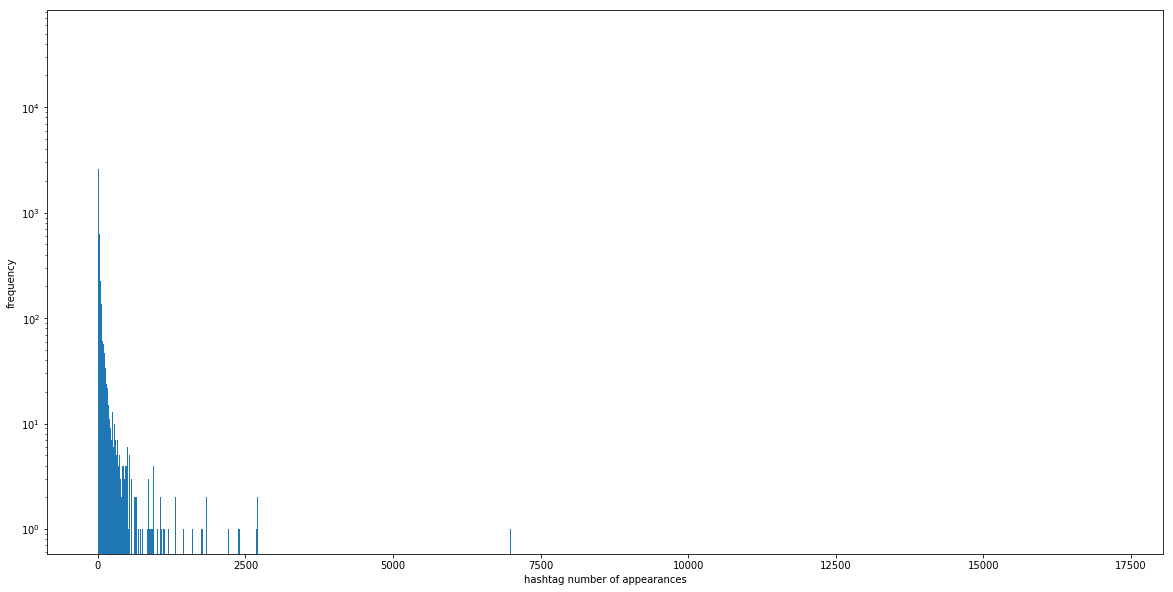

In [118]:
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure(figsize=(20,10))
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [121]:
popular_hashtags = counts.reset_index()
popular_hashtags.columns = ['hashtag', 'counts']
# popular_hashtags.dtypes

min_appearance = 1000
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts.apply(lambda x: x > min_appearance)]['hashtag'])

print("Length of the popular hashtags set: ", len(popular_hashtags_set))
print()
print(popular_hashtags_set)

Length of the popular hashtags set:  100

{'SpecialTrains', 'KAG', 'MayDay', 'Chennai', 'CoronaWarriors', 'IndiaFightsCorona', 'MorningJoe', 'COVIDIOTS', 'India', '中島健人', 'whiteprivilege', 'BillGates', 'COVID', 'KAG2020', 'StayHome', 'HKProtests', 'LabourDay', 'vaccine', 'staysafe', 'Ramadan', 'LockdownExtended', 'COVID__19', 'Australia', 'covid', 'plandemic', 'CarrieLam', 'CoronaOutbreak', 'heysayjump', 'Wuhan', 'HongKongProtests', 'WorkersDay', 'FridayThoughts', 'LaborDay', 'KingPrince', 'LabourDay2020', 'Nigeria', 'PRC', 'StayHomeStaySafe', 'PPE', 'SARSCoV2', 'NHS', 'FridayMotivation', 'CoronaBeer', 'SocialDistancing', 'HongKong', 'Odisha', 'OdishaFightsCorona', 'TweetforTaiwan', 'Trump', 'SwasthaBharat', 'NOW', 'CautionYesPanicNo', 'ReopenAmericaNow', 'SexyZone', 'Tcot', 'Corona', 'Ccot', 'Iran', 'TaiwanModel', 'lockdown', 'Islamphobia_In_India', 'China', 'Masks4All', 'RENTRELIEF', 'StaySafe', 'WHO', 'Taiwan', 'Foxandfriends', 'freedom', 'fridaymorning', 'Lockdown', 'Comey', 'auspo

In [122]:
# make a new column with only the popular hashtags
df_entities['popular_hashtags'] = df_entities.hashtags.apply(lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = df_entities.loc[df_entities.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
popular_hashtags_list_df.head()

,id,entities,hashtags,popular_hashtags
4,1.256010e+18,"{'hashtags': [{'text': 'China', 'indices': [17...",[China],[China]
6,1.256010e+18,"{'hashtags': [{'text': 'QuarantineLifeBeLike',...","[QuarantineLifeBeLike, Job, QuarantineLife, lo...","[Lockdown, USA, StayAtHome]"
10,1.256010e+18,"{'hashtags': [{'text': 'JayaBhattacharya', 'in...","[JayaBhattacharya, KyunkiSaasBhiKabhiBahuThi, ...",[Lockdown]
32,1.256010e+18,"{'hashtags': [{'text': 'IndiaFightsCorona', 'i...","[IndiaFightsCorona, StayAtHomeSaveLives, StayH...","[IndiaFightsCorona, StayHomeStaySafe, StayHome..."
39,1.256010e+18,"{'hashtags': [{'text': 'MGMotor', 'indices': [...","[MGMotor, MGHector, SUV, Ambulance, India]",[India]


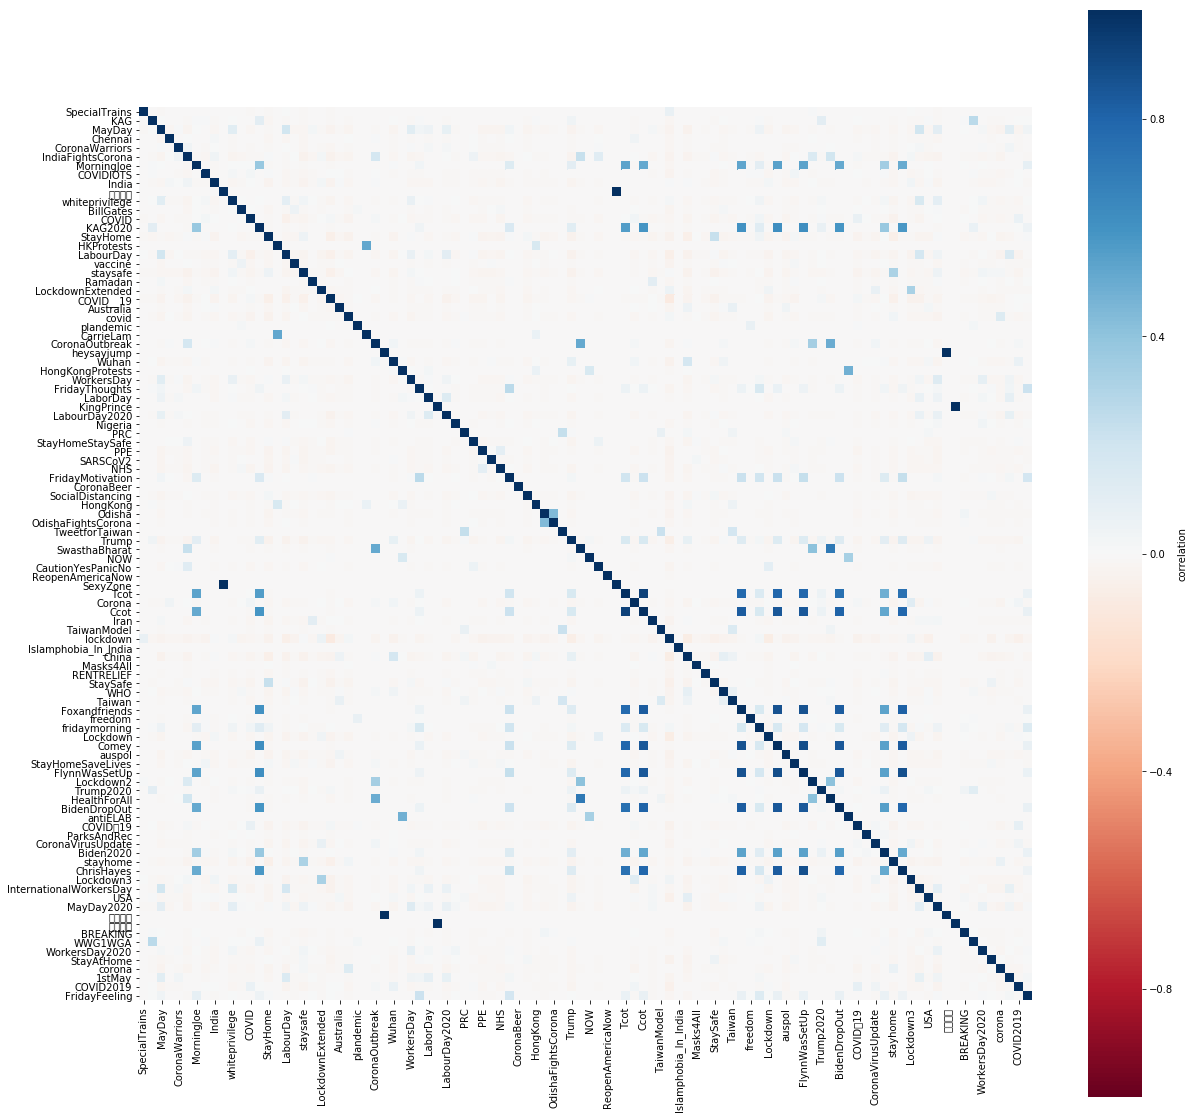

In [127]:

hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(lambda hashtag_list: int(hashtag in hashtag_list))
    
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.savefig('hashtags_correlation.png')
plt.show()


## Topic Modelling

#### Concatenating all days data and dropping duplicates as there might be overlaps in the tweets from two consecutive days

In [81]:
df_text = pd.concat(text_list)
df_text = df_text.drop_duplicates().reset_index(drop = True)

df_text = df_text[:100000]

df_text.tail()

,id,full_text
99995,1.256244e+18,The Hardcore Truth That Will Help Your Busines...
99996,1.256244e+18,Covid-19 and suicide: an uncertain connection ...
99997,1.256244e+18,This test by @CERN is pretty cool.\n\nMy resul...
99998,1.256244e+18,Is the fossil fuel industry experiencing a mom...
99999,1.256244e+18,"Our CMO, Padraic Gilligan talks about what the..."


In [129]:
df_text['entities'] = df_entities.entities
df_text.tail()

,id,full_text,entities
99995,1.256244e+18,The Hardcore Truth That Will Help Your Busines...,"{'hashtags': [{'text': 'coronavirus', 'indices..."
99996,1.256244e+18,Covid-19 and suicide: an uncertain connection ...,"{'hashtags': [{'text': 'covid19', 'indices': [..."
99997,1.256244e+18,This test by @CERN is pretty cool.\n\nMy resul...,"{'hashtags': [{'text': 'Covid19', 'indices': [..."
99998,1.256244e+18,Is the fossil fuel industry experiencing a mom...,"{'hashtags': [{'text': 'COVID19', 'indices': [..."
99999,1.256244e+18,"Our CMO, Padraic Gilligan talks about what the...","{'hashtags': [{'text': 'COVID19', 'indices': [..."


### Cleaning the tweet text

In [210]:
def checkEntity(x):
    try :  
        float(x)
#         print("entity: ", x)
        return True
    except : 
        return False
    
def get_text_cleaned(tweet):
    text = tweet['full_text']
    if(checkEntity(tweet['entities'])):
        return text
    
    entities = eval(tweet['entities'])

    slices = []
    #Strip out the urls.
    if 'urls' in entities:
        for url in entities['urls']:
            slices += [{'start': url['indices'][0], 'stop': url['indices'][1]}]
    
    #Strip out the hashtags.
    if 'hashtags' in entities:
        for tag in entities['hashtags']:
            slices += [{'start': tag['indices'][0], 'stop': tag['indices'][1]}]
    
    #Strip out the user mentions.
    if 'user_mentions' in entities:
        for men in entities['user_mentions']:
            slices += [{'start': men['indices'][0], 'stop': men['indices'][1]}]
    
    #Strip out the media.
    if 'media' in entities:
        for med in entities['media']:
            slices += [{'start': med['indices'][0], 'stop': med['indices'][1]}]
    
    #Strip out the symbols.
    if 'symbols' in entities:
        for sym in entities['symbols']:
            slices += [{'start': sym['indices'][0], 'stop': sym['indices'][1]}]
    
    # Sort the slices from highest start to lowest.
    slices = sorted(slices, key=lambda x: -x['start'])
    
    #No offsets, since we're sorted from highest to lowest.
    for s in slices:
        text = text[:s['start']] + text[s['stop']:]
    # Remove numbers
    text = re.sub('([0-9]+)', '', text)
    
    # Remove punctuations
    punctuations = '#!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
    text = re.sub('['+ punctuations + ']+', ' ', text)
    
    return text.lower()



def get_text_normalized(tweet):
    #Sanitize the text first.
    text = get_text_cleaned(tweet).split()
    
    stop_words = set(stopwords.words('english'))
    stop_words.update(['coronavirusoutbreak', 'coronavirusPandemic', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'covid19', 'covid-19'])
    
    #Remove the stop words.
    text = [t for t in text if t not in stop_words]
    
    #Create the stemmer.
#     stemmer = LancasterStemmer()
    
    #Stem the words.
#     return ' '.join([stemmer.stem(t) for t in text])
    return ' '.join(text)

In [211]:
df_text['cleaned_text'] = df_text.apply(get_text_normalized, axis = 1)
df_text.head()

,id,full_text,entities,cleaned_text
0,1.256010e+18,"As a response to COVID19, 30% of companies sur...","{'hashtags': [{'text': 'SequoiaHR', 'indices':...",response covid companies surveyed offering hom...
1,1.256010e+18,@NCDCgov Covid-19 Positive results coming from...,"{'hashtags': [{'text': 'COVID19', 'indices': [...",covid positive results coming kano alarming fr...
2,1.256010e+18,#keepseniorssafe Despite a severe uptick in pr...,"{'hashtags': [{'text': 'keepseniorssafe', 'ind...",despite severe uptick protocols procedures bey...
3,1.256010e+18,Maharashtra has reached the grim milestone of ...,"{'hashtags': [{'text': 'coronavirus', 'indices...",maharashtra reached grim milestone plus cases ...
4,1.256010e+18,"People may blame #China for #COVID19, but many...","{'hashtags': [{'text': 'China', 'indices': [17...",people may blame many chinese citizens actuall...


In [212]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=0.01, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_text['cleaned_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
tf_feature_names[:10]

['across',
 'also',
 'another',
 'april',
 'around',
 'back',
 'best',
 'better',
 'business',
 'businesses']

In [213]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [214]:
n_topics = 10
# model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model = NMF(n_components=n_topics, random_state=0, alpha=.1, l1_ratio=.5)
model.fit(tf)
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,cases,15.5,workers,12.7,’s,15.1,people,16.1,covid,16.1,us,15.9,new,16.4,may,15.0,pandemic,16.1,help,8.9
1,total,6.1,day,11.1,it,4.1,many,0.8,news,1.0,join,1.1,month,0.8,lockdown,4.0,global,1.7,get,5.7
2,deaths,5.8,happy,3.9,’t,1.5,million,0.6,via,0.7,let,1.0,today,0.4,weeks,2.1,world,1.3,home,5.6
3,confirmed,2.2,today,2.6,”,1.0,government,0.5,global,0.7,china,0.8,total,0.4,th,2.0,last,1.0,need,5.3
4,number,1.9,health,2.1,let,1.0,virus,0.5,read,0.6,world,0.6,reported,0.4,two,1.6,says,0.9,time,5.2
5,positive,1.9,thank,1.9,i,0.6,tested,0.4,patients,0.6,trump,0.6,happy,0.3,pm,1.1,report,0.9,stay,4.1
6,reported,1.7,work,1.7,trump,0.5,’t,0.4,positive,0.5,deaths,0.6,world,0.3,month,1.0,could,0.9,work,4.1
7,today,1.4,essential,1.6,world,0.5,lockdown,0.4,fight,0.4,keep,0.5,also,0.2,day,0.9,years,0.9,one,3.9
8,state,1.2,working,1.3,know,0.5,number,0.4,impact,0.4,thank,0.5,data,0.2,india,0.7,news,0.8,support,3.7
9,update,1.1,world,1.0,important,0.4,like,0.4,crisis,0.4,safe,0.5,report,0.2,end,0.6,two,0.8,like,3.6


In [215]:
n_topics = 10
model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
# model = NMF(n_components=n_topics, random_state=0, alpha=.1, l1_ratio=.5)
model.fit(tf)
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,us,5663.8,people,8176.3,world,3575.6,’t,3111.4,’s,7425.9,covid,6592.8,cases,7868.7,workers,4935.6,one,3491.2,home,3596.2
1,work,3501.0,health,2810.2,crisis,2711.1,get,2855.7,news,2168.0,may,6143.1,new,7139.8,like,3782.8,even,2152.2,via,2922.5
2,free,1876.1,need,2540.9,read,2159.2,virus,2744.1,let,2145.3,day,4001.2,deaths,4071.1,back,1899.5,social,1912.1,stay,2611.0
3,thank,1670.0,care,2351.8,good,2146.9,lockdown,2554.1,global,1934.9,pandemic,2744.2,total,2933.1,fight,1676.1,testing,1844.3,safe,1945.4
4,response,1509.1,time,1984.3,way,1664.7,see,2377.9,it,1749.1,two,1911.6,death,1942.9,times,1632.1,spread,1822.2,pm,1580.9
5,china,1431.1,first,1958.9,must,1616.1,trump,2155.4,”,1553.3,weeks,1784.4,number,1754.1,right,1561.1,year,1466.9,state,1480.6
6,check,1398.2,help,1922.9,around,1313.0,know,1760.9,keep,1523.3,lockdown,1496.0,data,1397.6,would,1519.7,positive,1420.7,patients,1427.0
7,make,1383.7,take,1683.4,post,1305.1,really,1209.9,uk,1439.9,says,1397.6,today,1391.9,going,1295.6,test,1394.8,month,1409.4
8,community,1372.1,still,1680.9,days,1297.7,mask,1192.4,business,1333.7,another,1283.1,update,1368.1,support,1273.2,well,1231.8,live,1337.7
9,join,1303.8,outbreak,1283.1,impact,1285.1,great,1102.1,government,1323.8,th,1209.1,reported,1357.1,essential,1250.1,said,1208.3,watch,1325.6
